In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd '/content/drive/My Drive/Studies 2/Year 2/Final Project/project_git_repo/code'

In [3]:
# !pip install scanpy
# !pip install stlearn 
# !pip install matplotlib==3.4.3
# !pip install preprocessing

In [4]:
%load_ext autoreload
%autoreload 2
from load_data import Data
from train import engine
import stlearn as st
import numpy as np
import torch
from torch.utils.data import TensorDataset
import os
from sklearn.model_selection import train_test_split
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

C:\Users\alon2\anaconda3\envs\FPST\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\alon2\anaconda3\envs\FPST\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# Load Visium Data with stlearn

In [5]:
dataset_name = 'data/V1_Human_Lymph_Node'

In [6]:
data = st.Read10X(dataset_name)
data

C:\Users\alon2\anaconda3\envs\FPST\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4035 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [7]:
X = data.X.toarray()

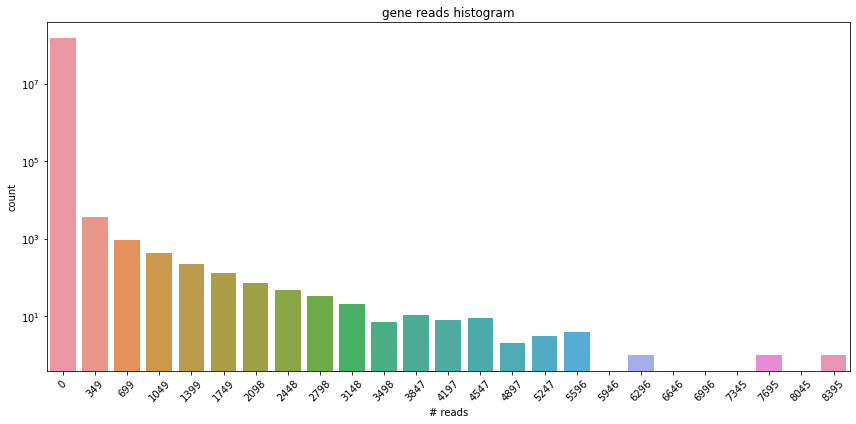

In [8]:
bin_count, bin_val = np.histogram(X, bins=25)
plt.figure(figsize=(12, 6))
plt.title('gene reads histogram')
plt.ylabel('count')
plt.xlabel('# reads')
sns.barplot(x=bin_val[:-1].astype(int), y=bin_count)
plt.yscale('log')
plt.xticks(rotation = 45)
plt.show()

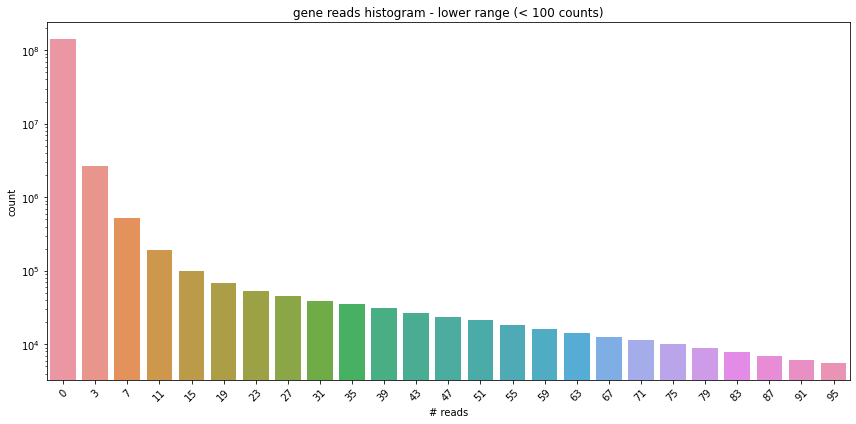

In [9]:
bin_count, bin_val = np.histogram(X[X < 100], bins=25)
plt.figure(figsize=(12, 6))
plt.title('gene reads histogram - lower range (< 100 counts)')
plt.ylabel('count')
plt.xlabel('# reads')
sns.barplot(x=bin_val[:-1].astype(int), y=bin_count)
plt.yscale('log')
plt.xticks(rotation = 45)
plt.show()

In [10]:
bin_count, bin_val = np.histogram(X[(X < 100) & (X > 0)], bins=25)

# The final bin will include the entire range, adding it
bin_count = np.hstack([bin_count, np.zeros(2)])
bin_val = np.hstack([bin_val, np.ones(1) * np.inf])

X_flat = X.flatten()
all_indices = np.arange(X_flat.shape[0])
nonzero_indices = np.where(X_flat)[0]

In [11]:
DESIRED_DROPOFF_RATIO = 0.1

dropped_indices = np.random.choice(nonzero_indices, 
                                   size=int(nonzero_indices.shape[0] * DESIRED_DROPOFF_RATIO),
                                   replace=False)

print(f'dropped nonzero indices: {dropped_indices.shape[0]}')
print(f'drop ratio (nonzero): {dropped_indices.shape[0] / nonzero_indices.shape[0]:.2f}')
print(f'drop ratio (original): {dropped_indices.shape[0] / X_flat.shape[0]:.2f}')


X_dropped = X.copy()
X_dropped[np.unravel_index(dropped_indices, X.shape)] = 0
X_dropped

print(f'Non zero values - original n {(X > 0).sum()}, post-drop n {(X_dropped > 0).sum()}')

dropped nonzero indices: 2371710
drop ratio (nonzero): 0.10
drop ratio (original): 0.02
Non zero values - original n 23717106, post-drop n 21345396


In [12]:
# col_idx = np.tile(np.arange(X.shape[1]), (X.shape[0]))
# row_idx = np.repeat(np.arange(X.shape[0]), (X.shape[1]))
# vals = X.flatten()

# # print(col_idx.shape, row_idx.shape, vals.shape)
# pair_array = np.vstack((col_idx, row_idx, vals)).T

In [13]:
# test_idx = 1008483
# print(col_idx[test_idx])
# print(row_idx[test_idx])
# print(pair_array[test_idx])
# print(X[row_idx[test_idx], col_idx[test_idx]])

In [14]:
# Train set will be made of all the non-dropped indices 
train_indices = all_indices[~np.isin(all_indices, dropped_indices)]

# The dropped indices will be used as validation and test sets
validation_indices, test_indices = train_test_split(dropped_indices, train_size=0.1)

# Check that train+val+test give the otiginal shape
assert train_indices.shape[0] + validation_indices.shape[0] + test_indices.shape[0] == X_flat.shape[0]

In [17]:
BATCH_SIZE = 1024
NUM_WORKERS = 2
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dataset_name = 'V1_Human_Lymph_Node'
# train_array = pair_array[train_indices]
dataset = Data(dataset=dataset_name, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, device = DEVICE)
dataset.set_dataloaders()

V1_Human_Lymph_Node


C:\Users\alon2\anaconda3\envs\FPST\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [18]:
number_of_genes = data.n_vars
number_of_spots = data.n_obs

# NMF

In [19]:
from models import NMF

In [20]:
params = {
    'learning_rate': 0.001,
    'optimizer': "RMSprop",
    'latent_dim': 20,
    'batch_size': 512
}

In [21]:
nmf_model = NMF(number_of_genes, number_of_spots, params, DEVICE)

NameError: name 'device' is not defined

In [ ]:
train_nmf = engine(model = nmf_model,
                    model_name = 'NMF',
                    params = params,
                    epochs = 100,
                    dl_train = dataset.dl_train,
                    dl_test = dataset.dl_test,
                    device = DEVICE)

In [ ]:
nmf_train_losses, nmf_test_losses = train_nmf.execute()

In [ ]:
plt.title("RMSE loss")
plt.plot(np.sqrt(nmf_train_losses), color="red")
plt.plot(np.sqrt(nmf_test_losses), color="blue")

# NN- MF

In [ ]:
%load_ext autoreload
%autoreload 2
from models import NNMF
from torch import nn

## 1 Linear Layer

In [ ]:
params = {
    'learning_rate': 0.001,
    'optimizer': "Adam",
    'latent_dim': 256,
    'batch_size': 512,
    'layers_sizes': [(256,10)]
}

In [ ]:
nnmf_model = NNMF(number_of_genes, number_of_spots, params, 'cpu')

In [ ]:
train_nnmf = engine(model = nnmf_model,
                    model_name = 'NNMF',
                    params = params,
                    epochs = 100,
                    dl_train = train_dataloader,
                    dl_test = val_dataloader,
                    device = 'cpu')

In [ ]:
nnmf_utrain_losses, nnmf_test_losses = train_nnmf.execute()

## 3 Linear Layers

In [ ]:
params = {
    'learning_rate': 0.001,
    'optimizer': "Adam",
    'latent_dim': 20,
    'batch_size': 512,
    'layers_sizes': [(40,100), (100,50), (50,10)]
}

In [ ]:
nnmf_model = NNMF(number_of_genes, number_of_spots, params, 'cuda')

In [ ]:
train_nnmf = engine(model = nnmf_model,
                   model_name = 'NNMF',
                    params = params,
                    epochs = 100,
                    dl_train = dataset.dl_train,
                    dl_test = dataset.dl_test,
                    device = 'cpu')

In [ ]:
nnmf_train_losses, nnmf_test_losses = train_nnmf.execute()

# NeuMF

In [ ]:
%load_ext autoreload
%autoreload 2
from models import NeuMF

In [ ]:
params = {
    'learning_rate': 0.001,
    'optimizer': "Adam",
    'latent_dim': 20,
    'batch_size': 512,
    'layers_sizes': [40, 10]
}

In [ ]:
neumf_model = NeuMF(number_of_genes, number_of_spots, params, 'cpu')

In [ ]:
train_neumf = engine(model = neumf_model,
                    model_name = 'NeuMF',
                    params = params,
                    epochs = 5,
                    dl_train = dataset.dl_train,
                    dl_test = dataset.dl_test,
                    device = 'cpu')

In [ ]:
neumf_train_losses, neumf_test_losses = train_neumf.execute()

In [ ]:
plt.title("RMSE loss- Train")
plt.plot(np.sqrt(neumf_train_losses), color="red")
plt.plot(np.sqrt(neumf_test_losses), color="blue")